# Quantitative Risk Management

Click <a href="https://colab.research.google.com/github/Lolillosky/QuantRiskManagement/blob/main/NOTEBOOKS/8_IRS_Sensitivities.ipynb">
    <img src="https://upload.wikimedia.org/wikipedia/commons/d/d0/Google_Colaboratory_SVG_Logo.svg" width="30" alt="Google Colab">
</a> to open this notebook in Google Colab.


In this exercise, you are going to bootstrap a zero coupon curve from par swap rates. With this curve and a given volatility, you are going to price a swaption using the Bachelier formula. Then, you are going to compute, with the help of AD, the sensitivities of the swaption with respect to zero coupon rates. Then, you will transform these to sensitivities to par swap rates.

## Import main libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd



## Import the following libraries from the repository:

In [3]:
import sys
sys.path.append('../CODE')  # Adjust the path as necessary


from IPython.display import clear_output
'''
!rm -r {'QuantRiskManagement'}

!git clone https://github.com/Lolillosky/QuantRiskManagement.git

import sys
sys.modules.pop
sys.path.insert(0,'QuantRiskManagement/CODE')
'''
clear_output()


In [4]:
import pytorch_spline
import pytorch_option_formulas
import pytorch_ir_curve

## Load the swap data

In '../DATA/IR_Swap.csv', you have par swap rates for different maturities:

(0.0, 0.037106)

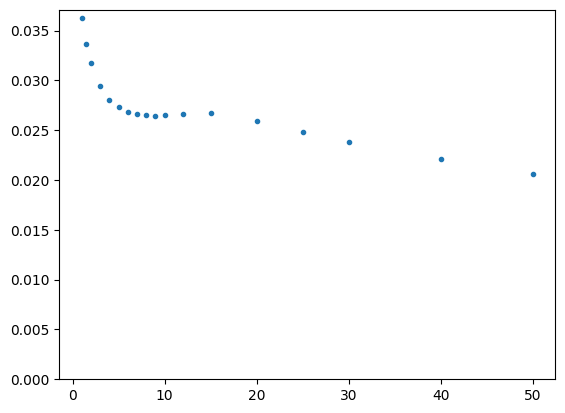

In [5]:
swap_rates = pd.read_csv('../DATA/IR_Swap.csv')
#swap_rates = pd.read_csv('/content/QuantRiskManagement/DATA/IR_Swap.csv')

swap_rates['Rate'] /= 100

plt.plot(swap_rates['Mat (yrs)'], swap_rates['Rate'], '.')
plt.ylim((0))

## Explore Pytorch spline function

In pytorch_spline.py module, you have a Pythorch implementation of a Pytorch spline function. Let us see how it works:

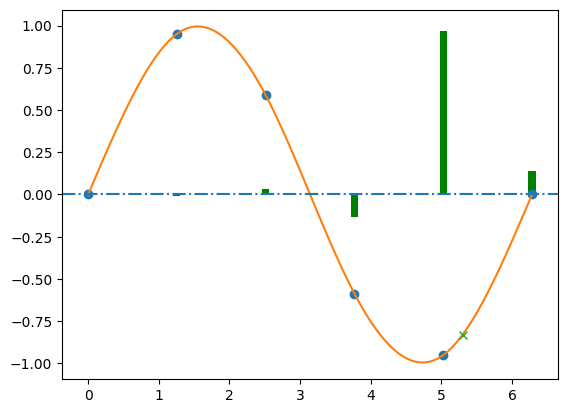

In [6]:
# We generate a discrete representation of the sin curve with numpy.
x = np.linspace(0,2*np.pi, 6)
y = np.sin(x)

# We generate Pytorch tensors from the numpy arrays.
x = torch.tensor(x, requires_grad=False) # We do not want to compute derivatives with respect to these.
y = torch.tensor(y, requires_grad=True) # We want to compute derivatives with respect to these.

# We generate a populated Pytorch tensor in the x dimension.
x_grid = torch.linspace(0,2*np.pi, 100,requires_grad=False) # We do not want to compute derivatives with respect to these.

# To initialize the spline, we just have to instanciate it with the data points.
spline = pytorch_spline.NaturalCubicSpline_Torch(x,y)

# We compute the spline interpolation for the populated grid.
with torch.no_grad():
    y_grid = spline.evaluate_spline(x_grid)

# We plot the spline interpolation for the populated grid together with the discrete data points used to build the spline.
plt.plot(x, y.detach(), 'o')
plt.plot(x_grid, y_grid)

# For a given x we compute the y interpolated by the spline function.
x_0 = torch.tensor(5.3, requires_grad=False)
y_0 = spline.evaluate_spline(x_0)

# We compute the derivative of y_0 with respect to the spline inputs.
y_0.backward()

grad = y.grad

# We plot the gradients.

plt.bar(x = x, height= grad, width= 0.1, color = 'green')
plt.plot(x_0, y_0.detach(), 'x')
plt.axhline(linestyle = '-.')



## IR Curve class, IRS pricing function, IR curve calibration.

In pytorch_ir_curve.py you have the following:

* class IR_Curve: An interest rate swap curve. Assumes cubic spline in rate*time.  
* class IR_Swap: A swap pricer.
* class CurveFitter: Implements the calibration of an IR curve from swap quotes.

The IR_Curve object is initialized with time pillars and zero coupon rates. Let's initialize it with the swap rates we have parsed (although swap rates are not ZC rates).

We can obtain ZC rates for every time step. Let's check the interpolation.

(0.0, 0.03910003514729934)

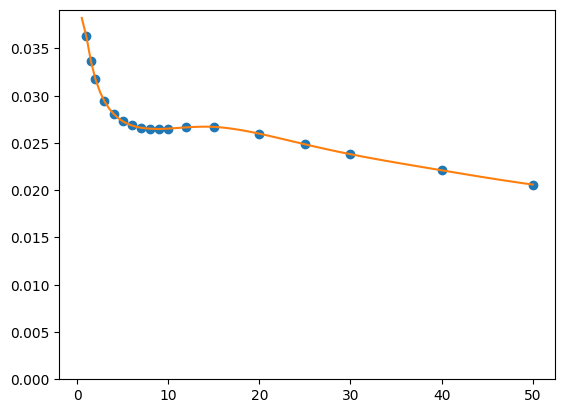

In [7]:
time = torch.tensor(swap_rates['Mat (yrs)'].values, requires_grad=False)
rates = torch.tensor(swap_rates['Rate'].values, requires_grad=False) 

curve = pytorch_ir_curve.IR_Curve(time, rates)

time_grid = torch.linspace(0,50,100, requires_grad=False)

zc_rates = curve.zero_coupon_rates(time_grid)

plt.plot(time, rates, 'o')
plt.plot(time_grid, zc_rates)
plt.ylim(0.0)




Here is how to use the swap pricer

In [8]:
swap = pytorch_ir_curve.IR_Swap(0,5,1)

swap.calc_par_rate(curve).item()

0.027821693155320803

And here how to use the curve fitter

In [9]:
fitter = pytorch_ir_curve.CurveFitter(swap_rates['Mat (yrs)'].values, swap_rates['Rate'].values, 1.0)

zc_rates = fitter.fit()

curve = pytorch_ir_curve.IR_Curve(torch.tensor(swap_rates['Mat (yrs)'].values), torch.tensor(zc_rates))

Let's plot swap rates and zero coupon rates.

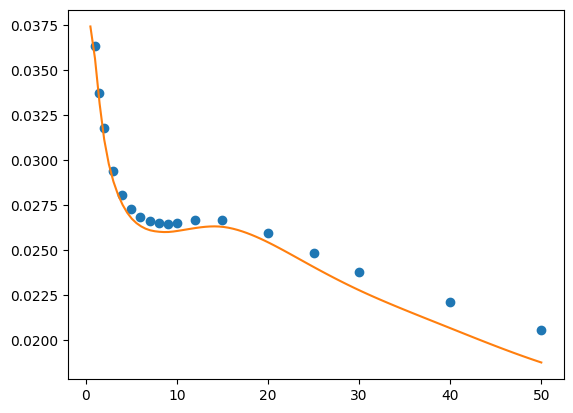

In [10]:
time_grid = torch.linspace(0,50,100, requires_grad=False)

zc_rates_grid = curve.zero_coupon_rates(time_grid)

plt.plot(swap_rates['Mat (yrs)'], swap_rates['Rate'], 'o')
plt.plot(time_grid, zc_rates_grid)


To price the swaption we use the following formula:

Payer swaption:

$$V_t = PV01(T,S) E_{\mathbb{A}}\left[\left(R_T-K\right)^+|\mathcal{F}_t\right]$$

Receiver swaption:

$$V_t = PV01(T,S) E\left[\left(K-R_T\right)^+|\mathcal{F}_t\right]$$

Where $PV01(T,S)$ is the forward annuity.

To compute $E_{\mathbb{A}}\left[\left(R_T-K\right)^+|\mathcal{F}_t\right]$ you must use the Bachelier model in pytorch_option_formulas.py


In [13]:
vol

0.0033